# Vector to Raster conversion

Transforming vector files to raster files for each data scenario

# Table of contents
##### 1. [Scenario 1: Verra and common-sense exclusion conditions](#Scenario-1)
[Base layer](#Base-layer)

1.1. [Forest current data](#Forest-current-data)

1.2. [Wetlands](#Wetlands)

1.3. [Organic soils](#Organic-soils)


1.4. [Agricultural parcels](#Agricultural-parcels)


1.5. [Water bodies and rivers](#Water-bodies-and-rivers)


1.6. [Transport infrastructure](#Transport-infrastructure)


1.7. [Built structures and associated spaces](#Built-structures-and-associated-spaces)


1.8. [Electric lines](#Electric-lines)
##### 2. [Scenario 2: Excluding ditches](#Scenario-2)
2.1. [Ditches](#Ditches)

##### 3. [Scenario 3: Excluding semi-natural grasslands](#Scenario-3)
3.1. [Semi-natural grasslands](#Semi-natural-grasslands)

# <a id="Scenario-1"></a>Scenario 1: Verra and common-sense exclusion conditions
[[Click here to turn back to the table of contents]](#Table-of-contents)

In [1]:
import rasterio
import fiona
from shapely.geometry import shape, Polygon
from tqdm import tqdm
from multiprocessing import Pool

from shapely.ops import unary_union
from shapely.ops import transform
from rasterio import features
import numpy as np
import os
import geopandas as gpd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib_scalebar.scalebar import ScaleBar

import rasterio
from rasterio.plot import show

In [2]:
def rasterize_vector(vector_layer_name, rasterized_layer_name, base_profile, base_trans, base_shape):
    '''
    vector_layer - vector layer to rasterize
    rasterized_layer_name - name for the rasterized layer
    base_profile - dict containing metadata and configuration for the raster file being created
    base_trans - spatial transformation information
    '''
    vector_layer = fiona.open(vector_layer_name)
    
    num_features_Layer = len(vector_layer)
    print("Number of features in the layer:", num_features_Layer)
    
    layer = []
        
    # Iterate over features in the vector layer
    for feature in tqdm(vector_layer):
        # Check if the id is not equal to 1
        if feature['geometry'] is not None:
            # Append the geometry of the feature to the layer list
            layer.append(shape(feature['geometry']))
     
    #rasterizing vector 
    rasterized = features.rasterize(layer, transform=base_trans,  out_shape=base_shape, dtype=np.uint8)[np.newaxis]

    #writing the rasterization result to the TIFF file
    with rasterio.open(rasterized_layer_name, 'w', **base_profile) as src:
        src.write(rasterized)

In [3]:
def plot_the_map(gdf, title, color, alpha=0.5):
    '''
    gdf - vector geodataframe to display
    title - title of a map
    color - color of polygons
    '''
    # Get bounds of the geometry
    bounds = gdf.total_bounds

    # Plot the shapefile
    fig, ax = plt.subplots(figsize=(8, 6))
    gdf.plot(ax=ax, color=color, alpha=alpha)#, edgecolor='black', linewidth=1.0)#
    
    estonia.plot(ax=ax, color='none', edgecolor='black', linewidth=0.4)

    # Set plot extent based on bounds
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])

    # Add title
    plt.title(title)

    # Plot the N arrow
    ax.text(0.1, 0.1, u'\u25B2\nN', transform=ax.transAxes,
        horizontalalignment='center', verticalalignment='bottom', zorder=2)

    # Add scale bar
    scalebar = ScaleBar(1, location='lower left')  # 1 pixel = 1 unit (adjust the value as needed)
    ax.add_artist(scalebar)

    plt.show()


In [4]:
def percent_of_area(geotiff_file):
    # Open the GeoTIFF file
    with rasterio.open(geotiff_file) as src:
        # Read the data
        data = src.read(1)

    # Create a boolean mask where True represents pixels with value 1
    mask = data == 1

    # Count the number of True values in the mask
    num_pixels = np.sum(mask)
    area_ha = round((num_pixels * 16)/10000)
    percent_of_estonia = round(area_ha/total_area_ha * 100, 1)

    print("Number of pixels equal to 1: {}".format(num_pixels))
    print("Area: {} ha".format(area_ha))
    print("% of the total area: {} %".format(percent_of_estonia))

In [6]:
#vector paths (input)
path_scenario_1_v = '../../Thesis_2024_updates/Vector_Data/Scenario_1/'
path_scenario_2_v = '../../Thesis_2024_updates/Vector_Data/Scenario_2/'
path_scenario_3_v = '../../Thesis_2024_updates/Vector_Data/Scenario_3/'

#raster paths (output)
path_scenario_1_r = '../../Thesis_2024_updates/Raster_Data/Scenario_1/'
path_scenario_2_r = '../../Thesis_2024_updates/Raster_Data/Scenario_2/'
path_scenario_3_r = '../../Thesis_2024_updates/Raster_Data/Scenario_3/'

### <a id="Base-layer"></a>Base layer
[[Click here to turn back to the table of contents]](#Table-of-contents)

In [7]:
#taking parameters from Estonian layer
file_name_whole_estonia_r = 'whole_estonia/Estonia_rasterized_0_1.tif'
raster_base_layer = os.path.join(path_scenario_1_r, file_name_whole_estonia_r)

with rasterio.open(raster_base_layer) as src:
    base_trans = src.transform
    base_profile = src.profile
    base_shape = src.shape
    base_data = src.read(1)
    
# Create a boolean mask where True represents pixels with value 1
mask = base_data == 1

# Count the number of True values in the mask
num_total_pixels = np.sum(mask)
total_area_ha = round((num_total_pixels * 16)/10000)

print("Number of pixels equal to 1:", num_total_pixels)
print("Total area of Estonia: {} ha".format(total_area_ha))


Number of pixels equal to 1: 2716698675
Total area of Estonia: 4346718 ha


In [8]:
file_name_estonia_v = 'whole_estonia/whole_Estonia_layer.shp'
estonia_v = os.path.join(path_scenario_1_v, file_name_estonia_v)
estonia = gpd.read_file(estonia_v)

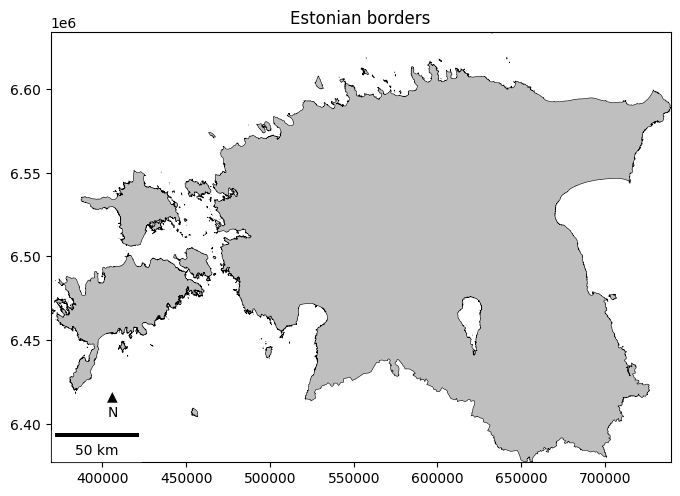

In [10]:
plot_the_map(estonia, 'Estonian borders', 'grey')

### <a id="Forest-current-data"></a>1.1. Forest current data
[[Click here to turn back to the table of contents]](#Table-of-contents)

##### * ETAK Data
[[Click here to turn back to the table of contents]](#Table-of-contents)

Filtering conditions: 
* "tyyp" = 10

In [11]:
#defining names of the working files
#vector file name
file_name_current_forest_ETAK_v = 'forest_current/E_305_puittaimestik_a.shp'
current_forest_ETAK_v = os.path.join(path_scenario_1_v, file_name_current_forest_ETAK_v)

#vector new filtered file
file_name_current_forest_ETAK_v_filtered = 'forest_current/E_305_puittaimestik_a_filtered.shp'
current_forest_ETAK_v_filtered = os.path.join(path_scenario_1_v, file_name_current_forest_ETAK_v_filtered)

#raster file name
file_name_current_forest_ETAK_r = 'forest_current/Current_forest_rasterized_python_ETAK.tif'
current_forest_ETAK_r = os.path.join(path_scenario_1_r, file_name_current_forest_ETAK_r)

======= Do not rerun cells below =======

In [ ]:
#loading data for filtering
gdf = gpd.read_file(current_forest_ETAK_v)
gdf.shape

In [11]:
#checking if "tyyp" is string or int or float
gdf.tyyp.unique(), type(gdf.tyyp.unique()[1])

(array([30, 10]), numpy.int64)

In [12]:
#filtering
filtered_gdf = gdf[gdf['tyyp'] == 10]

In [13]:
del gdf

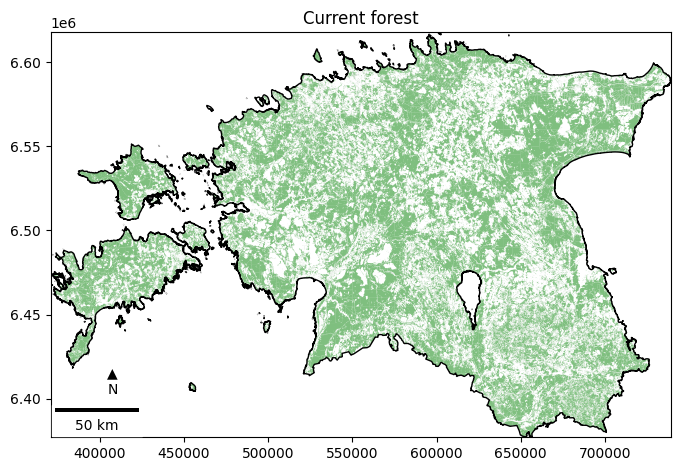

In [14]:
plot_the_map(filtered_gdf, 'Current forest', 'green')

In [15]:
filtered_gdf.to_file(current_forest_ETAK_v_filtered)

In [16]:
del filtered_gdf

In [17]:
#rasterizing the vector file
rasterize_vector(current_forest_ETAK_v_filtered, current_forest_ETAK_r, base_profile, base_trans, base_shape)

Number of features in the layer: 118537


100%|█████████████████████████████████| 118537/118537 [00:14<00:00, 8392.23it/s]


In [ ]:
# plot_geotiff(current_forest_ETAK_r, color='green', title='Forest ETAK')

##### * MetsaRegistry Data
[[Click here to turn back to the table of contents]](#Table-of-contents)

https://gsavalik.envir.ee/geoserver/metsaregister/ows

Filtering conditions: -


In [12]:
#defining names of the working files
#vector file name
file_name_current_forest_v = 'forest_current/metsaregistri_eraldised.shp'
current_forest_v_metsareg = os.path.join(path_scenario_1_v, file_name_current_forest_v)

#raster file name
file_name_current_forest_r = 'forest_current/Current_forest_rasterized_python_metsaregistry.tif'
current_forest_r_metsareg = os.path.join(path_scenario_1_r, file_name_current_forest_r)

In [146]:
rasterize_vector(current_forest_v_metsareg, current_forest_r_metsareg, base_profile, base_trans, base_shape)

Number of features in the layer: 1736624


100%|██████████████████████████████| 1736624/1736624 [01:41<00:00, 17146.63it/s]


##### * Combining Two Rasters
[[Click here to turn back to the table of contents]](#Table-of-contents)

---- The next cell was not causing kernel dying before, but now it does ----

In [13]:
# # Open the first raster
# with rasterio.open(current_forest_ETAK_r) as src1:
#     raster1 = src1.read(1)

# # Open the second raster
# with rasterio.open(current_forest_r_metsareg) as src2:
#     raster2 = src2.read(1)
    
# # Perform the calculations
# result = ((raster1 > 0) | (raster2 > 0)).astype('uint8')

---- Chunks approach ----

In [13]:
#raster file name
file_name_current_forest_combined_r = 'forest_current/Current_forest_rasterized_python_combined_1.tif'
current_forest_combined_r = os.path.join(path_scenario_1_r, file_name_current_forest_combined_r)

In [14]:
# Function for reading and processing a raster in chunks
def process_rasters(file_path1, file_path2, output_path):
    with rasterio.open(file_path1) as src1, rasterio.open(file_path2) as src2:
        # Defining window size (for example 1024x1024 pixels)
        window_size = 1024
        for ji, window in src1.block_windows(1):
            # Read data in a window for each file
            raster1 = src1.read(1, window=window)
            raster2 = src2.read(1, window=window)

            # Calculating result
            result_window = ((raster1 > 0) | (raster2 > 0)).astype('uint8')

            # Writing the result to a new file, if the window is the first, create a file
            if ji == (0, 0):
                profile = src1.profile
                profile.update(dtype='uint8', compress='lzw')
                with rasterio.open(output_path, 'w', **profile) as dst:
                    dst.write(result_window, 1, window=window)
            else:
                with rasterio.open(output_path, 'r+', **profile) as dst:
                    dst.write(result_window, 1, window=window)

# Paths to files
file_path1 = current_forest_ETAK_r
file_path2 = current_forest_r_metsareg
output_path = current_forest_combined_r

# Calling the function
process_rasters(file_path1, file_path2, output_path)

In [19]:
percent_of_area(current_forest_combined_r)

Number of pixels equal to 1: 1606032383
Forested area: 2569652 ha
% of the total area: 59.1 %


### <a id="Wetlands"></a>1.2. Wetlands
[[Click here to turn back to the table of contents]](#Table-of-contents)


Filtering conditions: -

In [8]:
#defining names of the working files
#vector file name
file_name_wetlands_v = 'wetlands/E_306_margala_a.shp'
wetlands_v = os.path.join(path_scenario_1_v, file_name_wetlands_v)

#raster file name
file_name_wetlands_r = 'wetlands/Wetlands_rasterized_python.tif'
wetlands_r = os.path.join(path_scenario_1_r, file_name_wetlands_r)

In [17]:
#rasterizing the vector file
rasterize_vector(wetlands_v, wetlands_r, base_profile, base_trans, base_shape)

Number of features in the layer: 55455


100%|███████████████████████████████████| 55455/55455 [00:06<00:00, 8943.23it/s]


In [9]:
#loading data for filtering
wetlands = gpd.read_file(wetlands_v)
wetlands.shape

(55455, 17)

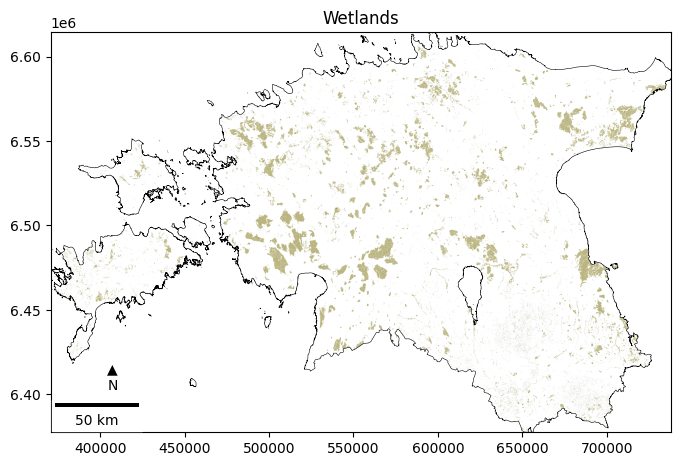

In [21]:
plot_the_map(wetlands, 'Wetlands', '#786e05')

In [20]:
percent_of_area(wetlands_r)

Number of pixels equal to 1: 207654742
Forested area: 332248 ha
% of the total area: 7.6 %


### <a id="Organic-soils"></a>1.3. Organic soils
[[Click here to turn back to the table of contents]](#Table-of-contents)

Filtering conditions: 
* "wrb_main" = 'HS'

In [23]:
#defining names of the working files
#vector file name
file_name_organic_soils_v = 'organic_soils/EstSoil-EH_v1.2c_filtered_histosoils.gpkg'
organic_soils_v = os.path.join(path_scenario_1_v, file_name_organic_soils_v)

#creating new filtered file
file_name_organic_soils_v_filtered = 'organic_soils/EstSoil-EH_v1.2c_filtered_histosoils.gpkg'
organic_soils_v_filtered = os.path.join(path_scenario_1_v, file_name_organic_soils_v_filtered)

#raster file name
file_name_organic_soils_r = 'organic_soils/Organic_soils_rasterized_python.tif'
organic_soils_r = os.path.join(path_scenario_1_r, file_name_organic_soils_r)

In [24]:
#loading data for filtering
organic_soils = gpd.read_file(organic_soils_v)
organic_soils.shape

(94115, 85)

In [25]:
#filtering
organic_soils.wrb_main.unique()

array(['HS'], dtype=object)

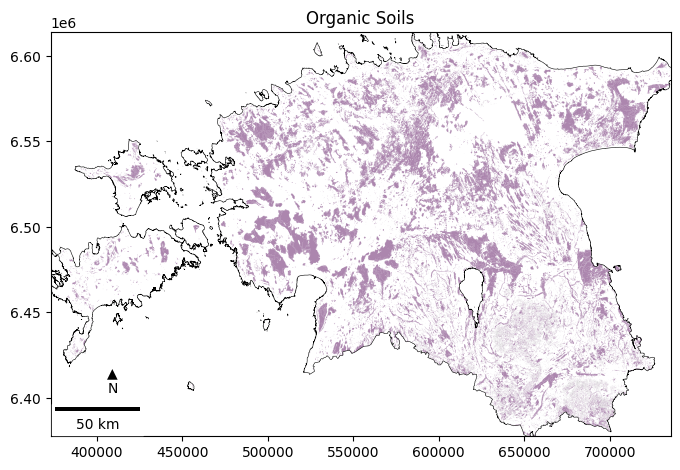

In [27]:
plot_the_map(organic_soils, 'Organic Soils', '#5a0f5f')

In [22]:
# filtered_gdf.to_file(organic_soils_v_filtered)

In [37]:
#rasterizing the vector file
rasterize_vector(organic_soils_v_filtered, organic_soils_r, base_profile, base_trans, base_shape)

Number of features in the layer: 94115


100%|███████████████████████████████████| 94115/94115 [00:13<00:00, 6816.99it/s]


In [23]:
percent_of_area(organic_soils_r)

Number of pixels equal to 1: 622609394
Forested area: 996175 ha
% of the total area: 22.9 %


### <a id="Agricultural-parcels"></a>1.4. Agricultural parcels
[[Click here to turn back to the table of contents]](#Table-of-contents)

Data: https://kls.pria.ee/geoserver/inspire_lpis/wfs ("Land Parcel Identification System Estonia Reference parcels")

Filtering conditions: -

In [29]:
#defining names of the working files
#vector file name
file_name_agricultural_parcels_v = 'agricultural_parcels/Land_Parcel_Identification_System_Estonia_Reference_parcels.shp'
agricultural_parcels_v = os.path.join(path_scenario_1_v, file_name_agricultural_parcels_v)

#raster file name
file_name_agricultural_parcels_r = 'agricultural_parcels/Agricultural_parcels_rasterized_python.tif'
agricultural_parcels_r = os.path.join(path_scenario_1_r, file_name_agricultural_parcels_r)

In [30]:
#loading data for filtering
agricultural_parcels = gpd.read_file(agricultural_parcels_v)
agricultural_parcels.shape

(143072, 8)

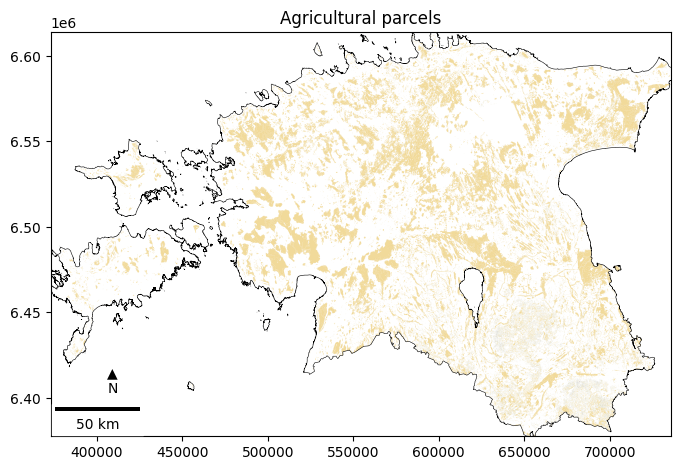

In [31]:
plot_the_map(organic_soils, 'Agricultural parcels', '#e5b636')

In [ ]:
#rasterizing the vector file
rasterize_vector(agricultural_parcels_v, agricultural_parcels_r, base_profile, base_trans, base_shape)

In [27]:
percent_of_area(agricultural_parcels_r)

Number of pixels equal to 1: 600746089
Forested area: 961194 ha
% of the total area: 22.1 %


### <a id="Water-bodies-and-rivers"></a>1.5. Water bodies and rivers
[[Click here to turn back to the table of contents]](#Table-of-contents)

##### Water bodies
[[Click here to turn back to the table of contents]](#Table-of-contents)

Filtering conditions: -

In [15]:
#defining names of the working files
#vector file name
file_name_water_bodies_v = 'water_bodies_and_rivers/E_202_seisuveekogu_a.shp'
water_bodies_v = os.path.join(path_scenario_1_v, file_name_water_bodies_v)

#raster file name
file_name_water_bodies_r = 'water_bodies_and_rivers/Water_bodies_rasterized_python.tif'
water_bodies_r = os.path.join(path_scenario_1_r, file_name_water_bodies_r)

In [10]:
water_bodies = gpd.read_file(water_bodies_v)

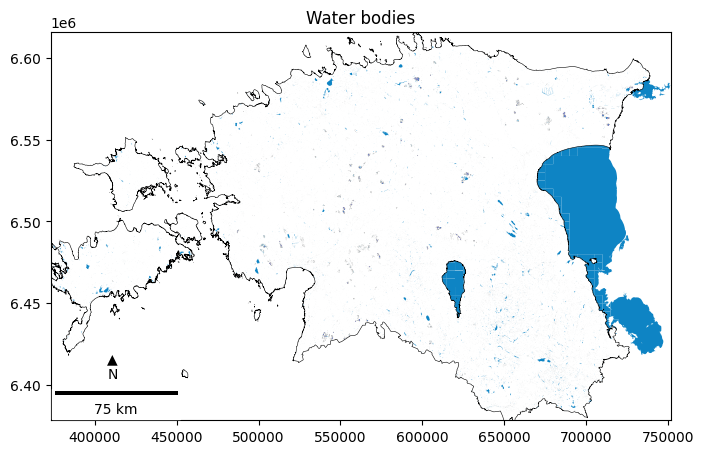

In [41]:
plot_the_map(water_bodies, 'Water bodies', '#0e84c4', alpha=1)

We need to clip the data. It was taking too long, when trying to do that in Jupyter Notebook, so it was clipped in QGIS.

In [20]:
# water_bodies.to_crs(estonia.crs, inplace=True)

In [21]:
# Clip the data using GeoPandas clip
# water_bodies_clip = gpd.clip(water_bodies, estonia)

# Clipping with python was taking too long, so I clipped with QGIS
#clipped file name
file_name_water_bodies_v_clipped = 'water_bodies_and_rivers/E_202_seisuveekogu_a_clipped.shp'
water_bodies_v_clipped = os.path.join(path_scenario_1_v, file_name_water_bodies_v_clipped)

#raster file name
file_name_water_bodies_r_clipped = 'water_bodies_and_rivers/Water_bodies_rasterized_python_clipped.tif'
water_bodies_r_clipped = os.path.join(path_scenario_1_r, file_name_water_bodies_r_clipped)

In [13]:
water_bodies_clipped = gpd.read_file(water_bodies_v_clipped)

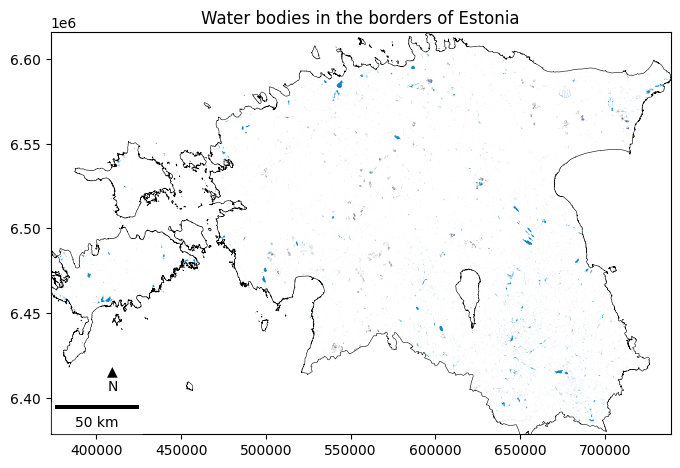

In [42]:
plot_the_map(water_bodies_clipped, 'Water bodies in the borders of Estonia', '#0e84c4', alpha=1)

In [ ]:
# water_bodies.to_crs(estonia.crs, inplace=True)

In [12]:
# ## 3D to 2D ===> do not need it after all
# from copy import copy
# import fiona
# from shapely.geometry import shape, mapping, Polygon, MultiPolygon

# def convert_3d_to_2d(geometry):
#     #Converting coords
#     def convert_coords(coords):
#         return [(x, y) for x, y, z in coords]

#     if geometry.geom_type == 'Polygon':
#         # Creating new Polygon without Z-coord
#         exterior = convert_coords(geometry.exterior.coords)
#         interiors = [convert_coords(interior.coords) for interior in geometry.interiors]
#         return Polygon(exterior, interiors)
#     elif geometry.geom_type == 'MultiPolygon':
#         # Creating new MultiPolygon without Z-coord 
#         polygons = []
#         for poly in geometry.geoms:
#             exterior = convert_coords(poly.exterior.coords)
#             interiors = [convert_coords(interior.coords) for interior in poly.interiors]
#             polygons.append(Polygon(exterior, interiors))
#         return MultiPolygon(polygons)
#     else:
#         raise ValueError("Unsupported geometry type")

# # Opening the original file 
# with fiona.open(water_bodies_v_clipped, 'r') as input:
#     #Creating new file for the results
#     output_schema = input.schema.copy()
#     output_schema['geometry'] = 'Polygon'

#     with fiona.open('{}_flattened.shp'.format(water_bodies_v_clipped[:-4]), 'w', 'ESRI Shapefile',
#                     schema=output_schema, crs=input.crs) as output:
#         for feature in input:
# #             print(feature.geometry)
#             if feature.geometry is not None:
#                 geom = shape(feature['geometry'])
#                 #print('Original Geometry:', geom)

#                 #Converting 3D geometry to 2D
#                 geom_2d = convert_3d_to_2d(geom)

#                 #print('Converted 2D Geometry:', geom_2d)

#                 #Saving the converted geometry to the output file
#                 output_feature = dict(feature)  # Создаем копию feature через прямое копирование
#                 #output_feature = copy(feature)
#                 output_feature['geometry'] = mapping(geom_2d)
#                 output.write(output_feature)
            
#             else:
#                 print("Error: feature.geometry is None")
#                 print('feature')
#                 print(feature)
#                 print('feature')
#                 for key, value in feature['properties'].items():
#                     print(f"  {key}: {value}")

Error: feature.geometry is None
feature
feature
  etak_id: 5197954
  kood: 202
  kood_t: Seisuveekogu
  tyyp: 10
  tyyp_t: Järv
  kkr_kood: VEE2075600
  nimetus: Peipsi järv
  knr_id: 100210043
  markused: None
  kpo_seos: 10
  kpo_seos_t: Keskkonnaregistri seisuveekogu
  vajalik: 30
  vajalik_t: Korras
  andmeallik: 219
  korgusalli: 219
  ruumikujua: 219
  muutmisaeg: 2022-07-08
  geom_muutm: 2022-07-08
  valjavote: 2024-04-06


In [149]:
#geometry with None value
water_bodies_clipped[water_bodies_clipped['etak_id'] == 5197954]

,etak_id,kood,kood_t,tyyp,tyyp_t,kkr_kood,nimetus,knr_id,markused,kpo_seos,kpo_seos_t,vajalik,vajalik_t,andmeallik,korgusalli,ruumikujua,muutmisaeg,geom_muutm,valjavote,geometry
768,5197954,202,Seisuveekogu,10,Järv,VEE2075600,Peipsi järv,100210043.0,NaN,10,Keskkonnaregistri seisuveekogu,30,Korras,219,219,219,2022-07-08,2022-07-08,2024-04-06,None


In [35]:
#rasterizing the vector file
rasterize_vector(water_bodies_v_clipped, water_bodies_r_clipped, base_profile, base_trans, base_shape)

Number of features in the layer: 119852


  0%|                                                | 0/119852 [00:00<?, ?it/s]ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

100%|████████████████████████████████| 119852/119852 [00:07<00:00, 16131.21it/s]


##### Rivers (polygon layer)
[[Click here to turn back to the table of contents]](#Table-of-contents)

Filtering conditions: -

In [18]:
#defining names of the working files
#vector file name
file_name_rivers_polygons_v = 'water_bodies_and_rivers/E_203_vooluveekogu_a.shp'
rivers_polygons_v = os.path.join(path_scenario_1_v, file_name_rivers_polygons_v)

#raster file name
file_name_rivers_polygons_r = 'water_bodies_and_rivers/Rivers_polygons_rasterized_python.tif'
rivers_polygons_r = os.path.join(path_scenario_1_r, file_name_rivers_polygons_r)

In [37]:
#loading data for filtering
rivers_polygons = gpd.read_file(rivers_polygons_v)
rivers_polygons.shape

(6481, 16)

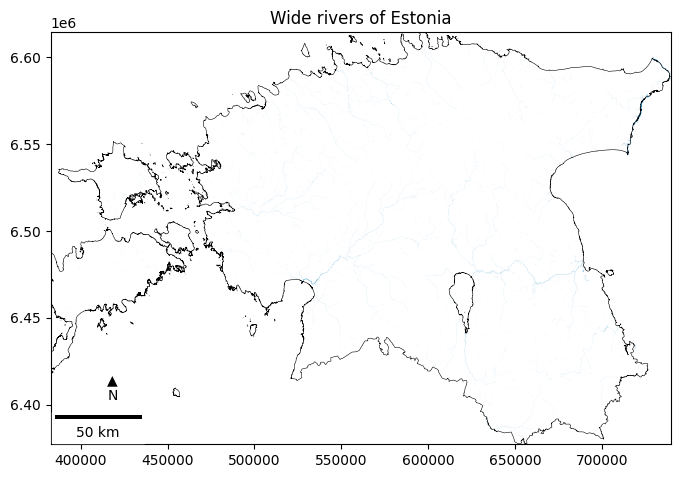

In [58]:
plot_the_map(rivers_polygons, 'Wide rivers of Estonia', '#0e84c4', alpha=1)

In [ ]:
#rasterizing the vector file
rasterize_vector(rivers_polygons_v, rivers_polygons_r, base_profile, base_trans, base_shape)

##### Rivers (line layer)
[[Click here to turn back to the table of contents]](#Table-of-contents)

Filtering conditions: 
* "laius" in (20, 30, 40)

In [24]:
#defining names of the working files
#vector file name
file_name_rivers_lines_v = 'water_bodies_and_rivers/E_203_vooluveekogu_j.shp'
rivers_lines_v = os.path.join(path_scenario_1_v, file_name_rivers_lines_v)

#vector new filtered file
file_name_rivers_lines_v_filtered_buffered = 'water_bodies_and_rivers/E_203_vooluveekogu_j_filtered_buffered.shp'
rivers_lines_v_filtered_buffered = os.path.join(path_scenario_1_v, file_name_rivers_lines_v_filtered_buffered)

#raster file name
file_name_rivers_lines_r = 'water_bodies_and_rivers/Rivers_lines_rasterized_python.tif'
rivers_lines_r = os.path.join(path_scenario_1_r, file_name_rivers_lines_r)

In [25]:
#loading data for filtering
rivers_lines = gpd.read_file(rivers_lines_v)
rivers_lines.shape

(955739, 25)

In [26]:
#checking if "laius" is string or int or float
rivers_lines.laius.unique(), type(rivers_lines.laius.unique()[1])

(array([10, 20, 30, 40, 50, 60]), numpy.int64)

In [27]:
#filtering
filtered_rivers_lines = rivers_lines[rivers_lines['laius'].isin([20, 30, 40])]
filtered_rivers_lines.shape

(514872, 25)

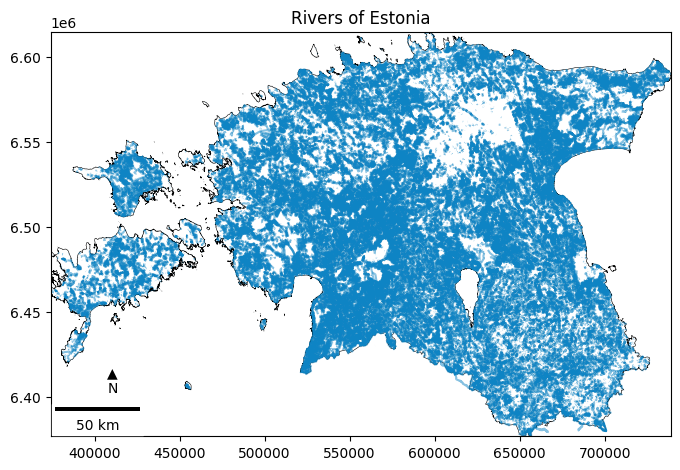

In [ ]:
plot_the_map(filtered_rivers_lines, 'Rivers of Estonia', '#0e84c4')

In [29]:
# import geopandas as gpd
# from shapely.geometry import LineString, MultiLineString

# Assuming rivers_lines is a GeoDataFrame with a 'laius' column and LineString geometries

# Define a function to create conditional buffers
def conditional_buffer(row):
    if row['laius'] == 20:
        return row.geometry.buffer(2)  # Buffer 2 meter to both sides for laius == 20
    elif row['laius'] == 30:
        return row.geometry.buffer(3)  # Buffer 3 meters for laius == 30
    elif row['laius'] == 40:
        return row.geometry.buffer(4)  # Buffer 4 meters for laius == 40
#     else:
#         return row.geometry  # No buffer for other values

# Apply the conditional buffer function to each row
buffered_geoms = filtered_rivers_lines.apply(lambda row: conditional_buffer(row), axis=1)

# Convert to GeoDataFrame
buffered_rivers_lines = gpd.GeoDataFrame(geometry=buffered_geoms)

# # If you have MultiPolygon geometries, you can convert them into separate rows
# buffered_rivers_lines_exploded = buffered_gdf.explode()

# # Reset index to avoid issues
# buffered_gdf_exploded.reset_index(drop=True, inplace=True)

# # Save to file
# buffered_gdf_exploded.to_file("buffered_lines.shp")

# Reset index to avoid issues
buffered_rivers_lines.reset_index(drop=True, inplace=True)

# Save to file
buffered_rivers_lines.to_file(rivers_lines_v_filtered_buffered)


In [30]:
#rasterizing the vector file
rasterize_vector(rivers_lines_v_filtered_buffered, rivers_lines_r, base_profile, base_trans, base_shape)

Number of features in the layer: 514872


100%|████████████████████████████████| 514872/514872 [00:42<00:00, 12084.84it/s]


##### * Combining Rasters
[[Click here to turn back to the table of contents]](#Table-of-contents)

In [11]:
# Raster file name
file_name_water_combined_r = 'water_bodies_and_rivers/Water_rasterized_python_combined.tif'
water_combined_r = os.path.join(path_scenario_1_r, file_name_water_combined_r)

In [32]:
# Function for reading and processing a raster in chunks
def process_rasters_2(file_path1, file_path2, file_path3, output_path):
    with rasterio.open(file_path1) as src1, rasterio.open(file_path2) as src2, rasterio.open(file_path3) as src3:
        # Defining window size (for example 1024x1024 pixels)
        window_size = 1024
        for ji, window in src1.block_windows(1):
            # Read data in a window for each file
            raster1 = src1.read(1, window=window)
            raster2 = src2.read(1, window=window)
            raster3 = src3.read(1, window=window)

            # Calculating result
            # result_window = ((raster1 > 0) | (raster2 > 0)).astype('uint8')
            result_window = ((raster1 > 0) | (raster2 > 0) | (raster3 > 0)).astype('uint8')

            # Writing the result to a new file, if the window is the first, create a file
            if ji == (0, 0):
                profile = src1.profile
                profile.update(dtype='uint8', compress='lzw')
                with rasterio.open(output_path, 'w', **profile) as dst:
                    dst.write(result_window, 1, window=window)
            else:
                with rasterio.open(output_path, 'r+', **profile) as dst:
                    dst.write(result_window, 1, window=window)

# Paths to files
file_path1 = water_bodies_r_clipped
file_path2 = rivers_polygons_r
file_path3 = rivers_lines_r
output_path = water_combined_r

# Calling the function
process_rasters_2(file_path1, file_path2, file_path3, output_path)

In [12]:
percent_of_area(water_combined_r)

Number of pixels equal to 1: 62048255
Forested area: 99277 ha
% of the total area: 2.3 %


### <a id="Transport-infrastructure"></a>1.6. Transport infrastructure
[[Click here to turn back to the table of contents]](#Table-of-contents)

Data: https://gsavalik.envir.ee/geoserver/kmakitsendused/wfs?version=2.0.0 ("Transport vöönd")

Filtering conditions: -

In [20]:
#defining names of the working files
#vector file name
file_name_transport_infrastructure_v = 'transport_infrastructure/Transport_vöönd.shp' 
transport_infrastructure_v = os.path.join(path_scenario_1_v, file_name_transport_infrastructure_v)

#raster file name
file_name_transport_infrastructure_r = 'transport_infrastructure/Transport_rasterized_python.tif'
transport_infrastructure_r = os.path.join(path_scenario_1_r, file_name_transport_infrastructure_r)

In [35]:
#rasterizing the vector file
rasterize_vector(transport_infrastructure_v, transport_infrastructure_r, 
                 base_profile, base_trans, base_shape)

Number of features in the layer: 5030


100%|█████████████████████████████████████| 5030/5030 [00:01<00:00, 4888.06it/s]


In [21]:
percent_of_area(transport_infrastructure_r)

Number of pixels equal to 1: 70773910
Forested area: 113238 ha
% of the total area: 2.6 %


### <a id="Built-structures-and-associated-spaces"></a>1.7. Built structures and associated spaces
[[Click here to turn back to the table of contents]](#Table-of-contents)

##### * dwelling or public building, subsidiary building or production facility, building under construction, foundation, ruins
[[Click here to turn back to the table of contents]](#Table-of-contents)

In [10]:
#defining names of the working files
#vector file name
file_name_buildings_v = 'built_structures_and_associated_places/E_401_hoone_ka.shp'
buildings_v = os.path.join(path_scenario_1_v, file_name_buildings_v)

#raster file name
file_name_buildings_r = 'built_structures_and_associated_places/Buildings_rasterized.tif'
buildings_r = os.path.join(path_scenario_1_r, file_name_buildings_r)

In [17]:
#loading data for filtering
buildings = gpd.read_file(buildings_v)
buildings.shape

(913752, 20)

In [37]:
#rasterizing the vector file
rasterize_vector(buildings_v, buildings_r, base_profile, base_trans, base_shape)

Number of features in the layer: 913752


100%|████████████████████████████████| 913752/913752 [00:48<00:00, 18779.32it/s]


##### * greenhouses, roofed area, other buildings/constructions (area >50m2)

In [11]:
#defining names of the working files
#vector file name
file_name_constructions_v = 'built_structures_and_associated_places/E_403_muu_rajatis_ka.shp'
constructions_v = os.path.join(path_scenario_1_v, file_name_constructions_v)

#raster file name
file_name_constructions_r = 'built_structures_and_associated_places/Other_constructions.tif'
constructions_r = os.path.join(path_scenario_1_r, file_name_constructions_r)

In [18]:
#loading data for filtering
constructions = gpd.read_file(constructions_v)
constructions.shape

(51465, 17)

In [38]:
#rasterizing the vector file
rasterize_vector(constructions_v, constructions_r, base_profile, base_trans, base_shape)

Number of features in the layer: 51465


100%|██████████████████████████████████| 51465/51465 [00:02<00:00, 20855.16it/s]


##### * subterranean facilities (cellar, garage etc)
[[Click here to turn back to the table of contents]](#Table-of-contents)

In [12]:
#defining names of the working files
#vector file name
file_name_subterranean_v = 'built_structures_and_associated_places/E_404_maaalune_hoone_ka.shp'
subterranean_v = os.path.join(path_scenario_1_v, file_name_subterranean_v)

#raster file name
file_name_subterranean_r = 'built_structures_and_associated_places/Subterranean_facilities.tif'
subterranean_r = os.path.join(path_scenario_1_r, file_name_subterranean_r)

In [19]:
#loading data for filtering
subterranean = gpd.read_file(subterranean_v)
subterranean.shape

(6329, 19)

In [39]:
#rasterizing the vector file
rasterize_vector(subterranean_v, subterranean_r, base_profile, base_trans, base_shape)

Number of features in the layer: 6329


100%|████████████████████████████████████| 6329/6329 [00:00<00:00, 18924.06it/s]


##### * yard (residential building area), production area (industrial building area)
[[Click here to turn back to the table of contents]](#Table-of-contents)

In [13]:
#defining names of the working files
#vector file name
file_name_yards_v = 'built_structures_and_associated_places/E_301_muu_kolvik_ka.shp'
yards_v = os.path.join(path_scenario_1_v, file_name_yards_v)

#raster file name
file_name_yards_r = 'built_structures_and_associated_places/Yards.tif'
yards_r = os.path.join(path_scenario_1_r, file_name_yards_r)

In [20]:
#loading data for filtering
yards = gpd.read_file(yards_v)
yards.shape

(2115, 18)

In [40]:
#rasterizing the vector file
rasterize_vector(yards_v, yards_r, base_profile, base_trans, base_shape)

Number of features in the layer: 2115


100%|████████████████████████████████████| 2115/2115 [00:00<00:00, 11412.33it/s]


##### * port, landfill/dumping ground, sporting facility/stadium, quarry, airfield, cemetery
[[Click here to turn back to the table of contents]](#Table-of-contents)

Filtering conditions: "tyyp_t" != 'Karjäär'

In [14]:
#defining names of the working files
#vector file name
file_name_facilities_v = 'built_structures_and_associated_places/E_301_muu_kolvik_ka.shp'
facilities_v = os.path.join(path_scenario_1_v, file_name_facilities_v)

# #vector new filtered file
file_name_facilities_v_filtered = 'built_structures_and_associated_places/E_301_muu_kolvik_ka_filtered.shp'
facilities_v_filtered = os.path.join(path_scenario_1_v, file_name_facilities_v_filtered)

#raster file name
file_name_facilities_r = 'built_structures_and_associated_places/Facilities.tif'
facilities_r = os.path.join(path_scenario_1_r, file_name_facilities_r)

In [21]:
#loading data for filtering
facilities = gpd.read_file(facilities_v)
facilities.shape

(2115, 18)

In [22]:
#filtering
filtered_facilities = facilities[facilities['tyyp_t'] != 'Karjäär']
filtered_facilities.shape

(1666, 18)

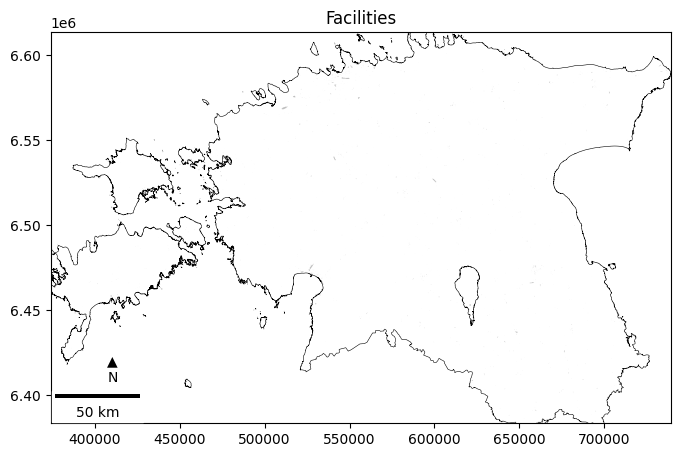

In [45]:
plot_the_map(filtered_facilities, 'Facilities', 'grey')

In [46]:
filtered_facilities.to_file(facilities_v_filtered)


In [47]:
#rasterizing the vector file
rasterize_vector(facilities_v_filtered, facilities_r, base_profile, base_trans, base_shape)

Number of features in the layer: 1666


100%|█████████████████████████████████████| 1666/1666 [00:00<00:00, 8768.29it/s]


##### * Combining Rasters
[[Click here to turn back to the table of contents]](#Table-of-contents)

In [48]:
# # Raster file name
# file_name_buildings_facilities_combined_r = 'built_structures_and_associated_places/Buildings_facilities_rasterized_python_combined.tif'
# buildings_facilities_combined_r = os.path.join(path_scenario_1_r, file_name_buildings_facilities_combined_r)

In [ ]:
# # Function for reading and processing a raster in chunks
# def process_rasters_3(file_path1, file_path2, file_path3, file_path4, file_path5, output_path):
#     with rasterio.open(file_path1) as src1, rasterio.open(file_path2) as src2, \
#     rasterio.open(file_path3) as src3, rasterio.open(file_path4) as src4, rasterio.open(file_path5) as src5:
#         # Defining window size (for example 1024x1024 pixels)
#         window_size = 1024
#         for ji, window in src1.block_windows(1):
#             # Read data in a window for each file
#             raster1 = src1.read(1, window=window)
#             raster2 = src2.read(1, window=window)
#             raster3 = src3.read(1, window=window)
#             raster4 = src4.read(1, window=window)
#             raster5 = src5.read(1, window=window)

#             # Calculating result
#             # result_window = ((raster1 > 0) | (raster2 > 0)).astype('uint8')
#             result_window = ((raster1 > 0) | (raster2 > 0) | (raster3 > 0) | (raster4 > 0) | (raster5 > 0)).astype('uint8')

#             # Writing the result to a new file, if the window is the first, create a file
#             if ji == (0, 0):
#                 profile = src1.profile
#                 profile.update(dtype='uint8', compress='lzw')
#                 with rasterio.open(output_path, 'w', **profile) as dst:
#                     dst.write(result_window, 1, window=window)
#             else:
#                 with rasterio.open(output_path, 'r+', **profile) as dst:
#                     dst.write(result_window, 1, window=window)

# # Paths to files
# file_path1 = buildings_r
# file_path2 = constructions_r
# file_path3 = subterranean_r
# file_path4 = yards_r
# file_path5 = facilities_r
# output_path = buildings_facilities_combined_r

# # Calling the function
# process_rasters_3(file_path1, file_path2, file_path3, file_path4, file_path5, output_path)

KeyboardInterrupt: 

##### * Another approach: combining vectors
[[Click here to turn back to the table of contents]](#Table-of-contents)

In [24]:
import pandas as pd

In [25]:
geo_list = [gdf[['geometry']] for gdf in [buildings, constructions, subterranean, yards, filtered_facilities]]

# Concatenate all GeoDataFrames into one
combined_gdf = gpd.GeoDataFrame(pd.concat(geo_list, ignore_index=True))
combined_gdf.shape

(975327, 1)

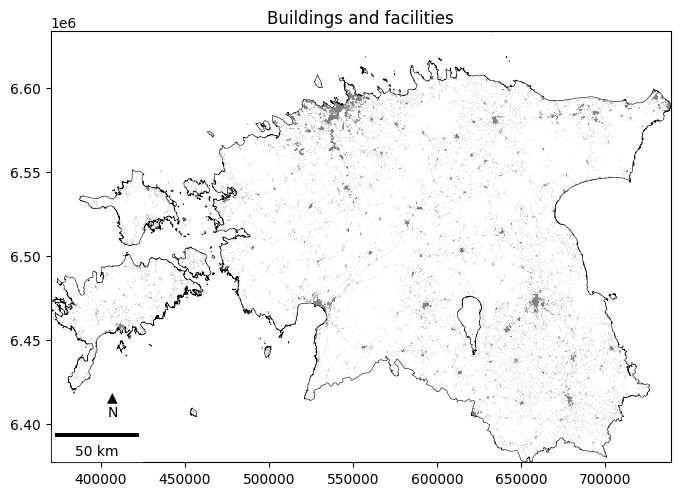

In [26]:
plot_the_map(combined_gdf, 'Buildings and facilities', 'grey')

In [15]:
#vector combined file
file_name_buildings_facilities_combined_v = 'built_structures_and_associated_places/Buildings_facilities_combined.shp'
buildings_facilities_combined_v = os.path.join(path_scenario_1_v, file_name_buildings_facilities_combined_v)

#raster combined file
file_name_buildings_facilities_combined_r = 'built_structures_and_associated_places/Buildings_facilities_combined.tif'
buildings_facilities_combined_r = os.path.join(path_scenario_1_r, file_name_buildings_facilities_combined_r)

In [57]:
combined_gdf.to_file(buildings_facilities_combined_v)

In [58]:
#rasterizing the vector file
rasterize_vector(buildings_facilities_combined_v, buildings_facilities_combined_r, base_profile, base_trans, base_shape)

Number of features in the layer: 975327


100%|████████████████████████████████| 975327/975327 [00:50<00:00, 19227.83it/s]


In [16]:
percent_of_area(buildings_facilities_combined_r)

Number of pixels equal to 1: 16568427
Forested area: 26509 ha
% of the total area: 0.6 %


### <a id="Electric-lines"></a>1.8. Electric lines
[[Click here to turn back to the table of contents]](#Table-of-contents)

Data: https://gsavalik.envir.ee/geoserver/kmakitsendused/wfs?version=2.0.0 ("Elekter vöönd")

Filtering conditions: 
* "ulatus" >= 10 and "ulatus" != 100

In [18]:
#defining names of the working files
#vector file name
file_name_electric_lines_v = 'electric_lines/Elekter_vöönd.shp'
electric_lines_v = os.path.join(path_scenario_1_v, file_name_electric_lines_v)

#vector new filtered file
file_name_electric_lines_v_filtered = 'forest_current/Elekter_vöönd_filtered.shp'
electric_lines_v_filtered = os.path.join(path_scenario_1_v, file_name_electric_lines_v_filtered)

#raster file name
file_name_electric_lines_r = 'electric_lines/Electric_lines_rasterized_python.tif'
electric_lines_r = os.path.join(path_scenario_1_r, file_name_electric_lines_r)

In [37]:
#loading data for filtering
electric_lines = gpd.read_file(electric_lines_v)
electric_lines.shape

(1226300, 15)

In [47]:
#checking if "ulatus" is string or int or float
electric_lines.ulatus.unique(), type(electric_lines.ulatus.unique()[1])

(array(['2', '1', '3', '100', '40', '10', '25'], dtype=object), str)

In [50]:
#filtering
#filtered_electric_lines = electric_lines[electric_lines['ulatus'] not in ('1', '100')]
filtered_electric_lines = electric_lines[~electric_lines['ulatus'].isin(['1', '100'])]
filtered_electric_lines.shape

(399638, 15)

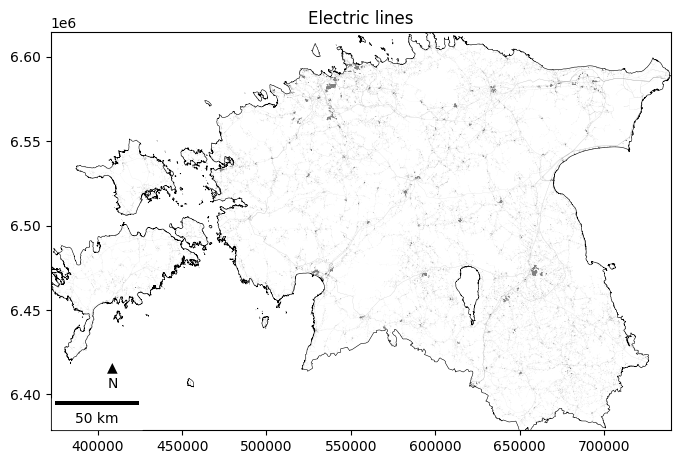

In [53]:
plot_the_map(filtered_electric_lines, 'Electric lines', 'grey')

In [54]:
filtered_electric_lines.to_file(electric_lines_v_filtered)

In [55]:
#rasterizing the vector file
rasterize_vector(electric_lines_v_filtered, electric_lines_r, base_profile, base_trans, base_shape)

Number of features in the layer: 399638


100%|████████████████████████████████| 399638/399638 [00:24<00:00, 16377.71it/s]


In [19]:
percent_of_area(electric_lines_r)

Number of pixels equal to 1: 47320945
Forested area: 75714 ha
% of the total area: 1.7 %


# <a id="Scenario-2"></a>Scenario 2: Excluding ditches
[[Click here to turn back to the table of contents]](#Table-of-contents)

### <a id="Ditches"></a>2.1. Ditches
[[Click here to turn back to the table of contents]](#Table-of-contents)

Filtering conditions: 
* "tyyp_t" in ('Kraav', 'Peakraav')

In [ ]:
#defining names of the working files
#vector file name
file_name_ditches_v = 'ditches/'
ditches_v = os.path.join(path_scenario_2_v, file_name_ditches_v)

#vector new filtered file
file_name_ditches_v_filtered = 'ditches/_filtered.shp'
ditches_v_filtered = os.path.join(path_scenario_2_v, file_name_ditches_v_filtered)

#raster file name
file_name_ditches_r = 'ditches/Ditches_rasterized_python.tif'
ditches_r = os.path.join(path_scenario_2_r, file_name_ditches_r)

In [ ]:
#loading data for filtering
ditches = gpd.read_file(current_forest_ETAK_v)
ditches.shape

#checking if "tyyp" is string or int or float
ditches.tyyp_t.unique(), type(ditches.tyyp_t.unique()[1])

del ditches
#filtering
filtered_ditches = ditches[ditches['tyyp'] == 10]

plot_the_map(filtered_ditches, 'Current forest', 'green')

filtered_ditches.to_file(ditches_v_filtered)

In [ ]:
#rasterizing the vector file
rasterize_vector(ditches_v, ditches_r, base_profile, base_trans, base_shape)

In [ ]:
# #vector new filtered file
# file_name_current_forest_ETAK_v_filtered = 'forest_current/E_305_puittaimestik_a_filtered.shp'
# current_forest_ETAK_v_filtered = os.path.join(path_scenario_1_v, file_name_current_forest_ETAK_v_filtered)

# #loading data for filtering
# gdf = gpd.read_file(current_forest_ETAK_v)
# gdf.shape

# #checking if "tyyp" is string or int or float
# gdf.tyyp.unique(), type(gdf.tyyp.unique()[1])

# #filtering
# filtered_gdf = gdf[gdf['tyyp'] == 10]

# plot_the_map(filtered_gdf, 'Current forest', 'green')

# filtered_gdf.to_file(current_forest_ETAK_v_filtered)

# #rasterizing the vector file
# rasterize_vector(current_forest_ETAK_v_filtered, current_forest_ETAK_r, base_profile, base_trans, base_shape)

# <a id="Scenario-3"></a>Scenario 3: Excluding semi-natural grasslands
[[Click here to turn back to the table of contents]](#Table-of-contents)

### <a id="Semi-natural-grasslands"></a>3.1. Semi-natural grasslands
[[Click here to turn back to the table of contents]](#Table-of-contents)

Filtering conditions: -

In [9]:
#defining names of the working files
#vector file name
file_name_grasslands_v = 'seminatural_grasslands/KKR pollooduslikud kooslused (PLK).shp'
grasslands_v = os.path.join(path_scenario_3_v, file_name_grasslands_v)

#raster file name
file_name_grasslands_r = 'seminatural_grasslands/Grasslands_rasterized_python.tif'
grasslands_r = os.path.join(path_scenario_3_r, file_name_grasslands_r)

In [10]:
#rasterizing the vector file
rasterize_vector(grasslands_v, grasslands_r, base_profile, base_trans, base_shape)

Number of features in the layer: 20608


100%|███████████████████████████████████| 20608/20608 [00:02<00:00, 8482.08it/s]


In [11]:
percent_of_area(grasslands_r)

Number of pixels equal to 1: 55426179
Forested area: 88682 ha
% of the total area: 2.0 %
